# **Cat vs Dog Classification with SVM**

## Cat vs Dog SVM

This notebook implements a Support Vector Machine (SVM) to classify cat and dog images from the Kaggle Cats vs Dogs dataset using RGB images.
We use a subset of the data to reduce computation time and include visualizations like confusion matrix, precision-recall curve, ROC curve, and an image grid of predictions.

In [72]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
from PIL import Image
from tqdm import tqdm
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Unzip and Prepare Dataset
Unzip the uploaded dataset and select a subset of images (1000 cats, 1000 dogs) to reduce computation time.
Adjust paths if your zip file or folder structure differs.

In [73]:
zip_file_path = '/train.zip'  # Update with your zip file name
data_dir = '/content/dataset/train'  # Update if structure differs

# Unzip dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# List cat and dog images
cat_files = [f for f in os.listdir(data_dir) if 'cat' in f.lower()]
dog_files = [f for f in os.listdir(data_dir) if 'dog' in f.lower()]

# Select subset
num_samples_per_class = 1000
random.shuffle(cat_files)
random.shuffle(dog_files)
cat_files = cat_files[:num_samples_per_class]
dog_files = dog_files[:num_samples_per_class]

print(f"Selected {len(cat_files)} cat images and {len(dog_files)} dog images.")

Selected 1000 cat images and 1000 dog images.


## Load and Preprocess Images
Load RGB images, resize to 64x64, and flatten to 1D vectors for SVM input.
RGB images use 3 channels, increasing memory usage compared to grayscale.

In [74]:
def load_and_preprocess_image(file_path, target_size=(64, 64)):
    """Load and preprocess an RGB image: resize and flatten."""
    img = Image.open(file_path).convert('RGB')  # Load as RGB
    img = img.resize(target_size)
    img_array = np.array(img).flatten()  # Flatten 64x64x3
    return img_array

X = []
y = []

print("Loading cat images...")
for file in tqdm(cat_files, desc="Cats"):
    img_path = os.path.join(data_dir, file)
    X.append(load_and_preprocess_image(img_path))
    y.append(0)  # 0 for cat

print("Loading dog images...")
for file in tqdm(dog_files, desc="Dogs"):
    img_path = os.path.join(data_dir, file)
    X.append(load_and_preprocess_image(img_path))
    y.append(1)  # 1 for dog

X = np.array(X)
y = np.array(y)

print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

Loading cat images...


Cats: 100%|██████████| 1000/1000 [00:02<00:00, 345.99it/s]


Loading dog images...


Dogs: 100%|██████████| 1000/1000 [00:02<00:00, 359.90it/s]


Dataset shape: (2000, 12288), Labels shape: (2000,)


## Split Data
Split the dataset into training (80%) and testing (20%) sets.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1600 samples
Test set: 400 samples


## Train SVM Model
Train an SVM with RBF kernel. Enable probability estimates for ROC and PR curves.
RGB images increase training time; use `kernel='linear'` or reduce `target_size` if slow.

In [76]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
print("Training SVM model...")
svm_model.fit(X_train, y_train)
print("Model training completed!")

Training SVM model...
Model training completed!


## Evaluate Model
Compute accuracy and display classification report.

In [77]:
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))


Test Accuracy: 57.50%

Classification Report:
              precision    recall  f1-score   support

         Cat       0.57      0.56      0.57       199
         Dog       0.58      0.59      0.58       201

    accuracy                           0.57       400
   macro avg       0.57      0.57      0.57       400
weighted avg       0.57      0.57      0.57       400



## Confusion Matrix
Visualize the confusion matrix to see true vs. predicted labels.

<Figure size 800x600 with 0 Axes>

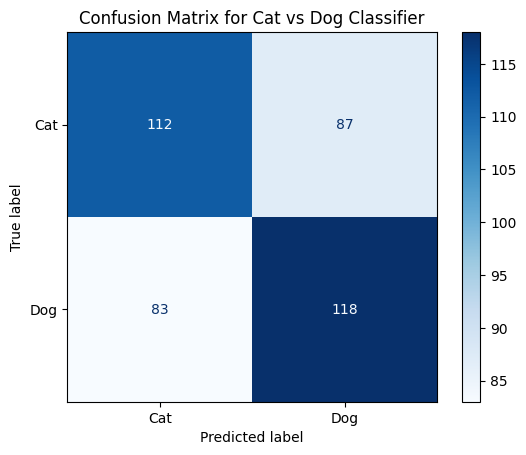

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Cat', 'Dog']).plot(cmap='Blues')
plt.title('Confusion Matrix for Cat vs Dog Classifier')
plt.show()

## Precision-Recall Curve
Plot the precision-recall curve to evaluate performance for imbalanced data.

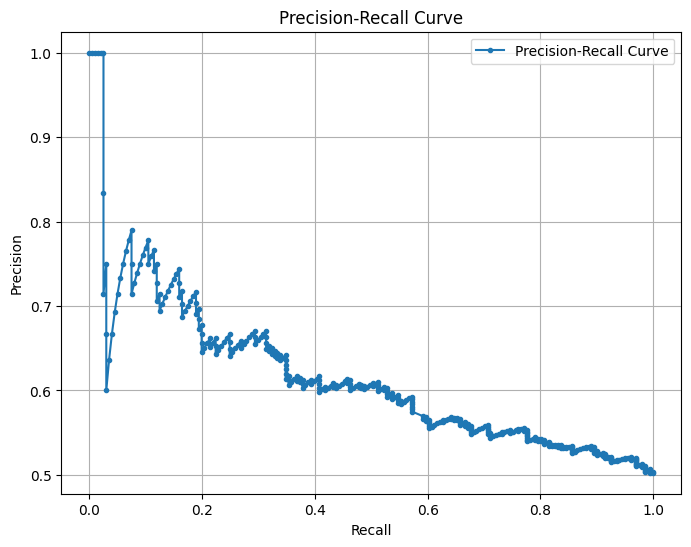

In [79]:
y_scores = svm_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## ROC Curve
Plot the ROC curve and compute the Area Under Curve (AUC).

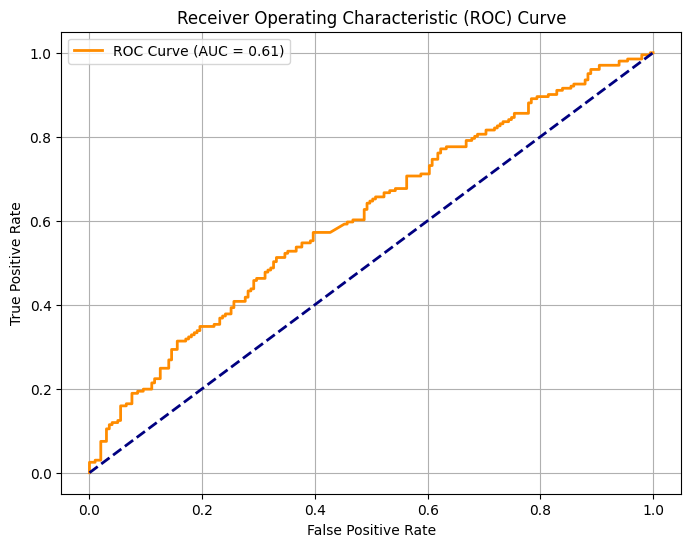

In [80]:
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

## Image Grid of Predictions
Display a 2x3 grid of colored test images with their true and predicted labels.

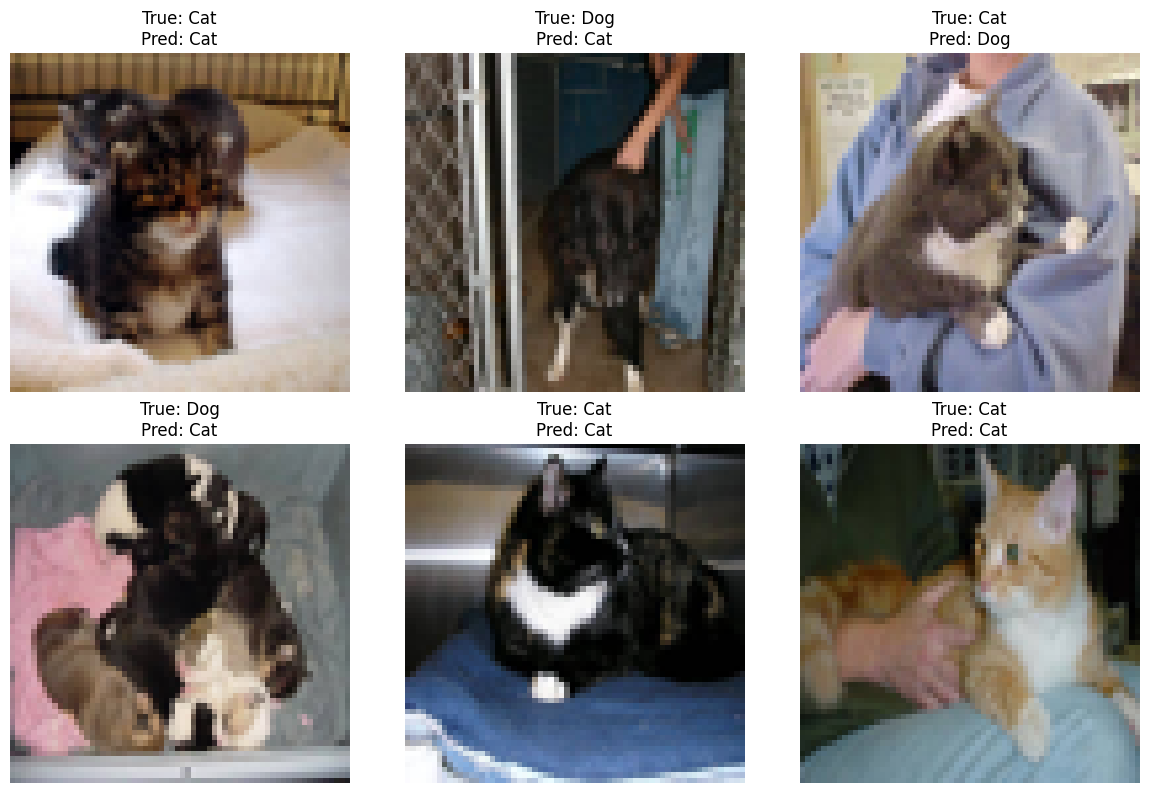

In [81]:
def visualize_predictions_grid(X_test, y_test, y_pred, num_rows=2, num_cols=3):
    """Display a grid of colored test images with true and predicted labels."""
    num_samples = num_rows * num_cols
    indices = random.sample(range(len(X_test)), num_samples)
    plt.figure(figsize=(num_cols * 4, num_rows * 4))

    for i, idx in enumerate(indices):
        img = X_test[idx].reshape(64, 64, 3)  # Reshape to 64x64x3 for RGB
        true_label = 'Cat' if y_test[idx] == 0 else 'Dog'
        pred_label = 'Cat' if y_pred[idx] == 0 else 'Dog'
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)  # Display RGB image
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions_grid(X_test, y_test, y_pred, num_rows=2, num_cols=3)

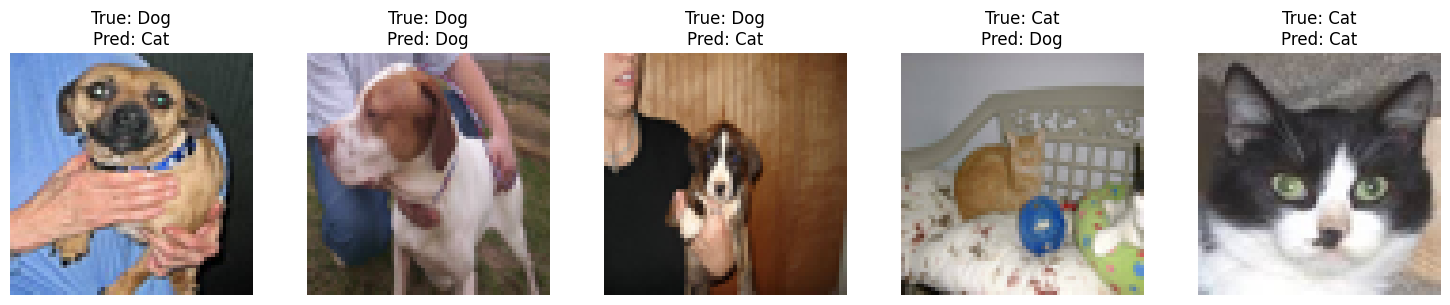

In [83]:
def visualize_predictions(X_test, y_test, y_pred, num_samples=5):
    """Display sample images with true and predicted labels."""
    indices = random.sample(range(len(X_test)), num_samples)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = X_test[idx].reshape(64, 64, 3) # Reshape to 64x64x3 for RGB
        true_label = 'Cat' if y_test[idx] == 0 else 'Dog'
        pred_label = 'Cat' if y_pred[idx] == 0 else 'Dog'
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img) # Display RGB image
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, y_pred)